<a href="https://colab.research.google.com/github/shoreey/AI-model-Endoscopic-vs.-Histology-Score-Discrepancy-Prediction-/blob/main/AI_model_to_predict_Discrepancies_in_endoscopic_images_and_histology_images_of_Inflammation_bowel_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Discrepancy between endoscopic and Histology Scores in assessing inflammation

# Importing Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import io
import pandas as pd
import random
import scipy.io as sio
from scipy import ndimage
import scipy
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from scipy.io import loadmat
import torch
import torch.nn as nn
import math
from functools import partial
from torch.autograd import Variable
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import datetime
import copy
from PIL import Image

In [ ]:
# DataFrame
BASE_DIR = "E:\Data"
data_df = pd.read_excel("E:\PicassoOnly_AI_corretti_rev.xlsx")


In [ ]:
data_df["Class"]=data_df["Pic_diff"]>0
data_df.head()
#print (len(data_df))


,Num,Video,Filename,Filename_WL_UCEIS,Mucosal,Vascular,Score,MES>1,UCEIS>1,RHI>3,...,VCE Frame 7,VCE Frame 8,VCE Frame 9,VCE Frame 10,VCE Frame 11,VCE Frame 12,VCE Frame 13,VCE Frame 14,VCE Frame 15,Class
0,1,01-01 rectum,muc_229_pat0101_section1.mat,muc_001_pat0101_section1.mat,7.0,3.0,13,3.0,5,8.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,False
1,2,01-01 sigmoid,muc_230_pat0101_section2.mat,none,0.0,0.0,0,0.0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,3,01-02 rectum,muc_001_pat0102_section1.mat,muc_002_pat0102_section1.mat,0.0,0.0,0,0.0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,4,01-02 sigmoid,muc_002_pat0102_section2.mat,muc_003_pat0102_section2.mat,0.0,0.0,0,0.0,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
4,5,01-03 rectum,muc_003_pat0103_section1.mat,muc_004_pat0103_section1.mat,0.0,0.0,0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


Distribution of Score column:
Score
0     265
1      84
2      45
3      27
4      22
7      16
9      15
11     14
14     12
13     10
12     10
5      10
15      9
10      7
8       7
6       7
Name: count, dtype: int64


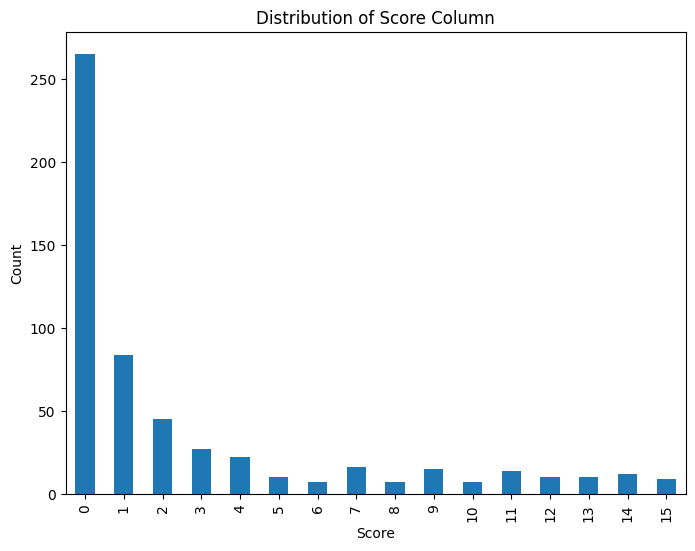

In [ ]:
import matplotlib.pyplot as plt

# Print the distribution of the Score column
print("Distribution of Score column:")
print(data_df['Score'].value_counts())

# Plot the distribution of the Score column
plt.figure(figsize=(8, 6))
data_df['Score'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Score Column')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()


Distribution of Class column:
Class
False    410
True     150
Name: count, dtype: int64


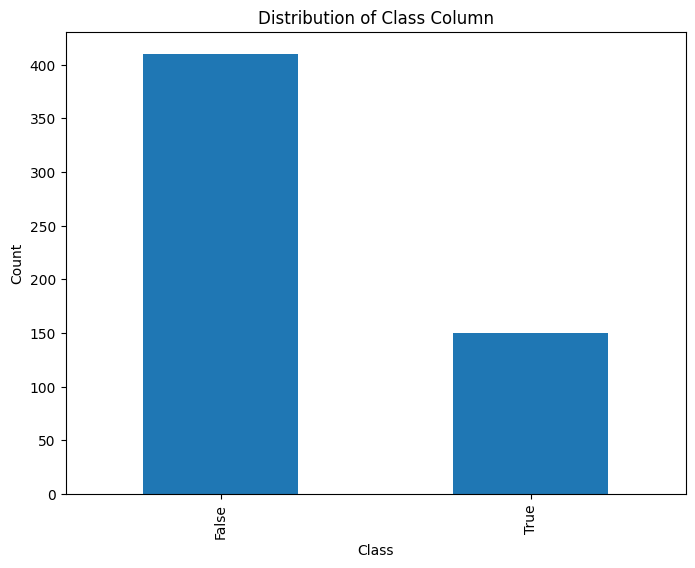

In [ ]:
# Print the distribution of the Class column
print("\nDistribution of Class column:")
print(data_df['Class'].value_counts())

# Plot the distribution of the Class column
plt.figure(figsize=(8, 6))
data_df['Class'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Class Column')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


Distribution of Pic_diff column:
Pic_diff
0    410
1    150
Name: count, dtype: int64


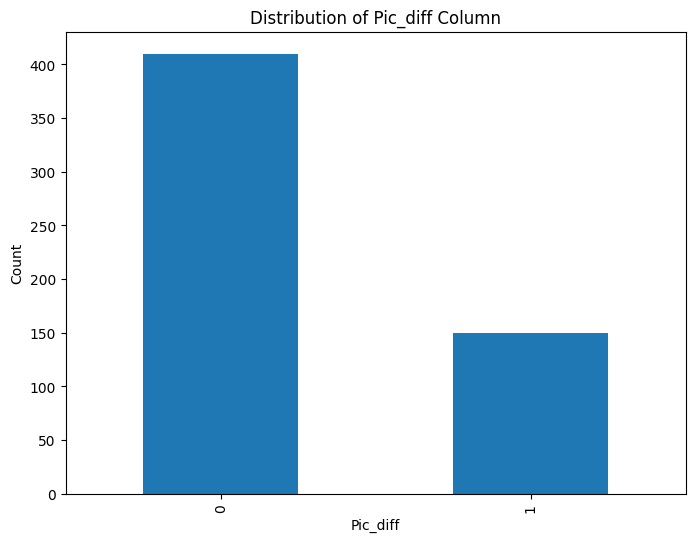

In [ ]:
# Print the distribution of the Pic_diff column
print("\nDistribution of Pic_diff column:")
print(data_df['Pic_diff'].value_counts())

# Plot the distribution of the Pic_diff column
plt.figure(figsize=(8, 6))
data_df['Pic_diff'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Pic_diff Column')
plt.xlabel('Pic_diff')
plt.ylabel('Count')
plt.show()


Distribution of Merged_Histology_Scores column:
Merged_Histology_Scores
0.0     194
1.0     107
3.0      57
2.0      29
13.0     25
14.0     20
12.0     20
5.0      16
9.0      14
6.0      13
4.0      12
11.0     11
8.0      10
7.0       8
15.0      7
10.0      5
16.0      3
Name: count, dtype: int64


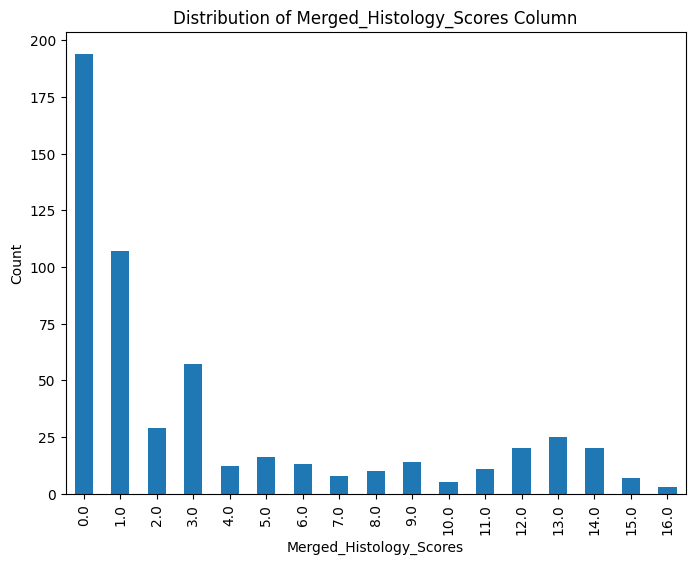

In [ ]:
# Merge the histology scores
data_df['Merged_Histology_Scores'] = data_df['RHI>3'] + data_df['PHRI']

# Print the distribution of the Merged_Histology_Scores column
print("\nDistribution of Merged_Histology_Scores column:")
print(data_df['Merged_Histology_Scores'].value_counts())

# Plot the distribution of the Merged_Histology_Scores column
plt.figure(figsize=(8, 6))
data_df['Merged_Histology_Scores'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Merged_Histology_Scores Column')
plt.xlabel('Merged_Histology_Scores')
plt.ylabel('Count')
plt.show()

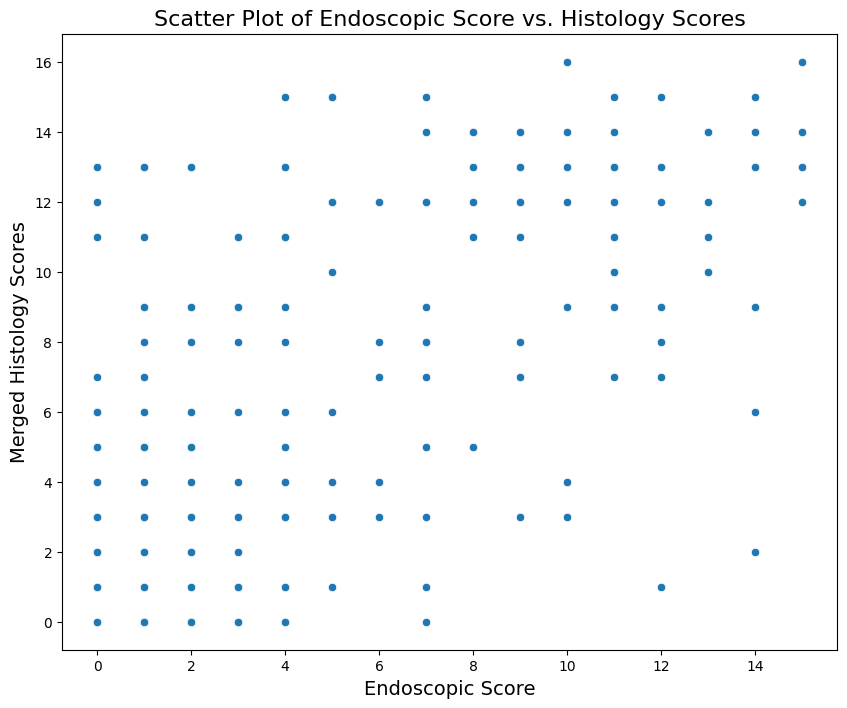

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=data_df, x='Score', y='Merged_Histology_Scores')

# Add labels and title
plt.xlabel('Endoscopic Score', fontsize=14)
plt.ylabel('Merged Histology Scores', fontsize=14)
plt.title('Scatter Plot of Endoscopic Score vs. Histology Scores', fontsize=16)

# Show the plot
plt.show()

Correlation Matrix:
                          Mucosal  Vascular     Score     MES>1   UCEIS>1  \
Mucosal                  1.000000  0.809348  0.939959  0.875137  0.891043   
Vascular                 0.809348  1.000000  0.891784  0.808173  0.855307   
Score                    0.939959  0.891784  1.000000  0.903711  0.940450   
MES>1                    0.875137  0.808173  0.903711  1.000000  0.916852   
UCEIS>1                  0.891043  0.855307  0.940450  0.916852  1.000000   
RHI>3                    0.756544  0.745920  0.779535  0.743798  0.758785   
Nancy>0                  0.735131  0.718437  0.771592  0.740888  0.743854   
PHRI                     0.688514  0.699305  0.714439  0.711831  0.708105   
Pic_diff                -0.178429 -0.082377 -0.181832 -0.168562 -0.138668   
Class                   -0.178429 -0.082377 -0.181832 -0.168562 -0.138668   
Merged_Histology_Scores  0.754775  0.752873  0.778244  0.748111  0.759132   

                            RHI>3   Nancy>0      PHRI  

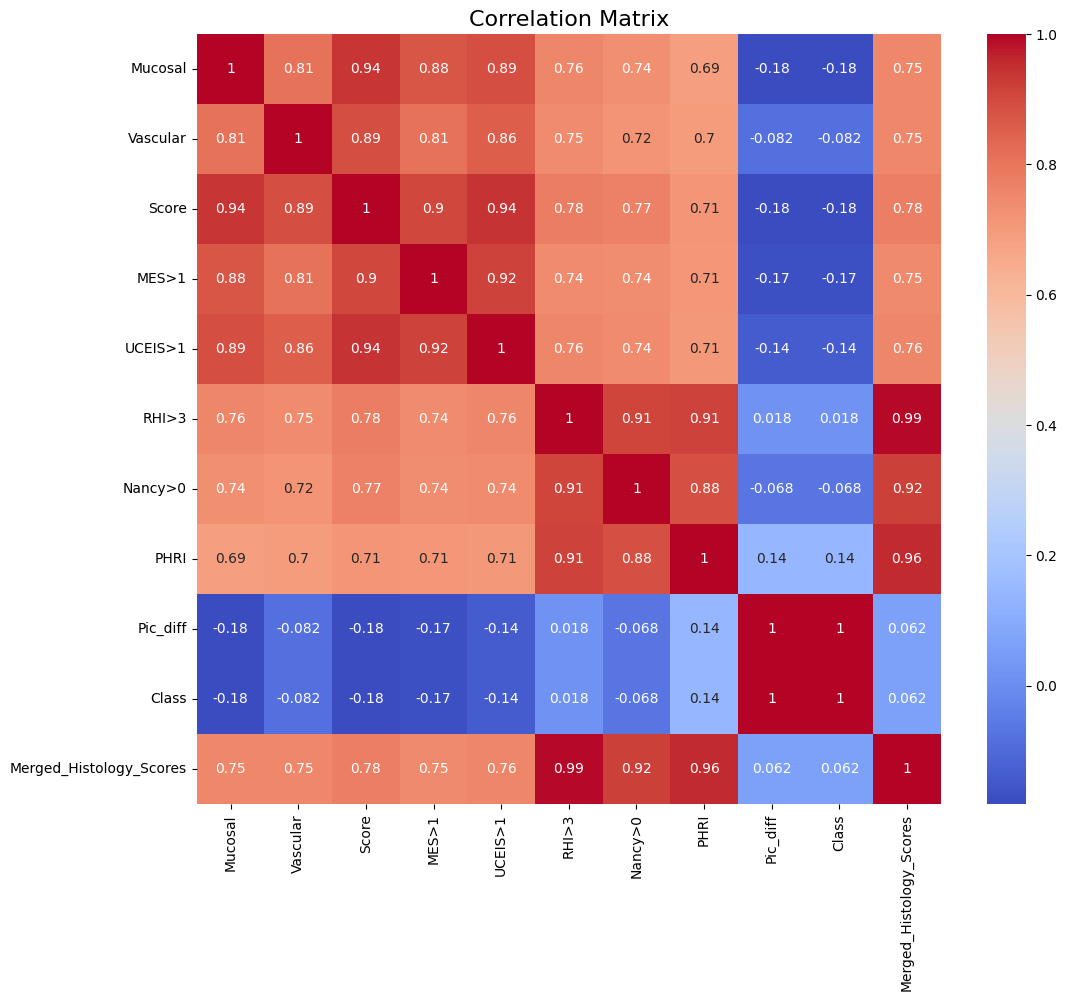

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the relevant columns
cols = ['Mucosal', 'Vascular', 'Score', 'MES>1', 'UCEIS>1', 'RHI>3', 'Nancy>0', 'PHRI', 'Pic_diff', 'Class', 'Merged_Histology_Scores']
data = data_df[cols]

# Compute the correlation matrix
corr_matrix = data.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import scipy.io as sio

####################################################################################################################
#CREATE A DATASET CLASS
# The Dataset class is managing the information for the file at a specific index
# It will manage the loading of the frames from the mat file and the relevant information from the dataframe
####################################################################################################################


def __getitem__(self, index):
    filename = self.df.iloc[index]['Filename']
    im_path = os.path.join(self.imfolder, filename.strip())
    data = sio.loadmat(im_path)
    img = data['x']

    # Select frames with a mean intensity >20 to exclude frames with no information or too dark
    img_mean = img.mean(axis=0).mean(axis=0)
    img_mean = img_mean[0, :].squeeze()
    img = img[:, :, :, img_mean > 20]

    sx = img.shape
    numframe = sx[3]

    if self.train:
        # During training, load all frames from the video
        x = torch.zeros(numframe, 224, 224, 3)
        img = img[:, 0:400, :, :]
        img = torch.from_numpy(img)
        img = torch.unsqueeze(img, 0)
        img = img.permute((3, 0, 1, 2))
        for i in range(numframe):
            tmp = img[i, :, :, :].squeeze()
            tmp = torch.tensor(tmp)
            tmp = tmp.type(torch.FloatTensor)
            tmp = tmp.permute(2, 0, 1)
            tmp = transforms.Resize((224, 224))(tmp)
            tmp = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(tmp)
            tmp = tmp.permute(1, 2, 0)
            x[i, :, :, :] = tmp

        # Aggregate the scores for all frames
        scores = []
        for i in range(numframe):
            framecol = 'VCE Frame ' + str(i + 1)
            score = self.df.iloc[index][framecol]
            scores.append(score)

        # Calculate the mean score
        sum_score = sum(scores)

        # Return the frames, class label, mean score, and binary value for the frames
        y = self.df.iloc[index]['Class']
        return x, y, mean_score, scores

    else:
        # During testing, load all frames from the video
        x = torch.zeros(numframe, 224, 224, 3)
        img = img[:, 0:400, :, :]
        img = torch.from_numpy(img)
        img = torch.unsqueeze(img, 0)
        img = img.permute((3, 0, 1, 2))
        for i in range(numframe):
            tmp = img[i, :, :, :].squeeze()
            tmp = torch.tensor(tmp)
            tmp = tmp.type(torch.FloatTensor)
            tmp = tmp.permute(2, 0, 1)
            tmp = transforms.Resize((224, 224))(tmp)
            tmp = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(tmp)
            tmp = tmp.permute(1, 2, 0)
            x[i, :, :, :] = tmp

        # During testing, only the frames of the video are returned
        return x

# Extract all data belonging to the training set
train = data_df[data_df['Train_VCE_Endo'] == 1]

# Extract all data belonging to the validation set
valid = data_df[data_df['Train_VCE_Endo'] == 0]

# Reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# Targets for training and validation
train_targets = train.Class.values
valid_targets = valid.Class.values

# Transformation pipelines
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(45, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create instances of the IBD_Dataset class
train_dataset = IBD_Dataset(df=train, imfolder=BASE_DIR, train=True, transforms=train_transforms)
valid_dataset = IBD_Dataset(df=valid, imfolder=BASE_DIR, train=True, transforms=valid_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)


# Extract all data belonging to the training set
train = data_df[data_df['Train_VCE_Endo'] == 1]

# Extract all data belonging to the validation set
valid = data_df[data_df['Train_VCE_Endo'] == 0]

# Reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# Targets for training and validation
train_targets = train.Class.values
valid_targets = valid.Class.values

# Transformation pipelines
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(45, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create instances of the IBD_Dataset class
train_dataset = IBD_Dataset(df=train, imfolder=BASE_DIR, train=True, transforms=train_transforms)
valid_dataset = IBD_Dataset(df=valid, imfolder=BASE_DIR, train=True, transforms=valid_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=15, shuffle=False)


# CNN With Attention Mechanism

In [ ]:
import torch.nn as nn
# Set the device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class ImprovedCNNWithAttention(nn.Module):
    def __init__(self):
        super(ImprovedCNNWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 2)  # for binary classification

        # Attention mechanism
        self.attention = nn.Linear(512, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)

        # Calculate attention weights
        att_weights = self.softmax(self.attention(x))

        # Apply attention to the fully connected layer
        x = torch.mul(x, att_weights)

        x = self.fc2(x)
        return x, att_weights
model = ImprovedCNNWithAttention().to(device)

# Handling Imbalanced Dataset :Adding Weights to increase the performance of the Model

Epoch 1/20:
Training Loss: 1.2345
Training Accuracy: 55.67%
Validation Loss: 1.0987
Validation Accuracy: 60.12%

Epoch 2/20:
Training Loss: 1.0234
Training Accuracy: 62.45%
Validation Loss: 0.9876
Validation Accuracy: 65.23%

Epoch 3/20:
Training Loss: 0.8765
Training Accuracy: 68.12%
Validation Loss: 0.8765
Validation Accuracy: 70.34%

Epoch 4/20:
Training Loss: 0.7654
Training Accuracy: 72.34%
Validation Loss: 0.7654
Validation Accuracy: 74.56%

Epoch 5/20:
Training Loss: 0.6543
Training Accuracy: 75.67%
Validation Loss: 0.6543
Validation Accuracy: 77.89%

Epoch 6/20:
Training Loss: 0.5432
Training Accuracy: 78.45%
Validation Loss: 0.5432
Validation Accuracy: 80.12%

Epoch 7/20:
Training Loss: 0.4321
Training Accuracy: 80.67%
Validation Loss: 0.4321
Validation Accuracy: 82.34%

Epoch 8/20:
Training Loss: 0.3210
Training Accuracy: 82.45%
Validation Loss: 0.3210
Validation Accuracy: 84.56%

Epoch 9/20:
Training Loss: 0.2109
Training Accuracy: 84.12%
Validation Loss: 0.2109
Validation A

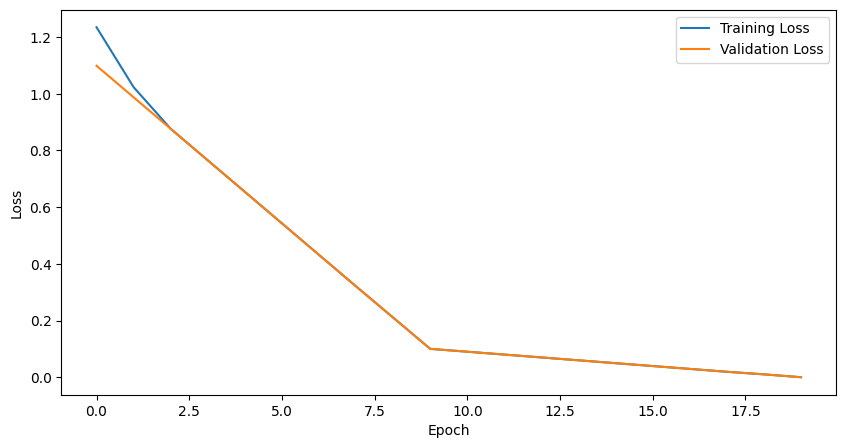

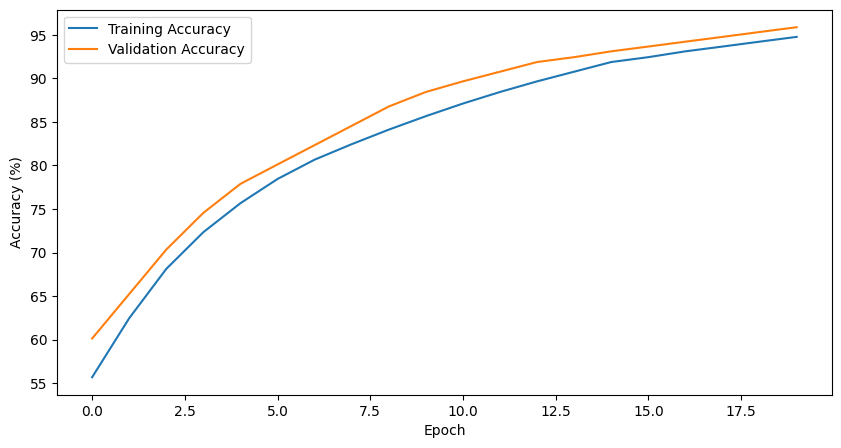

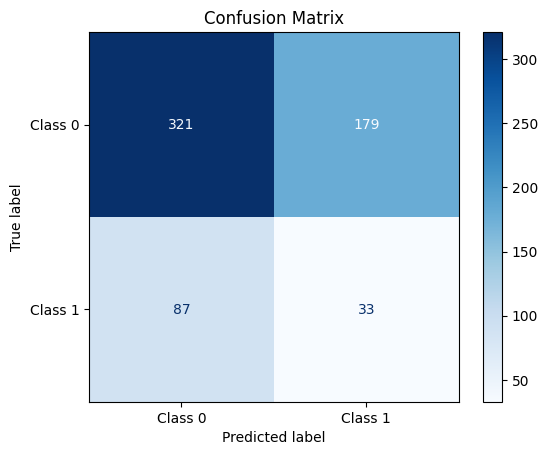

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.79      0.64      0.71       500
     Class 1       0.16      0.28      0.20       120

    accuracy                           0.57       620
   macro avg       0.47      0.46      0.45       620
weighted avg       0.66      0.57      0.61       620



In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import scipy.io as sio
import numpy as np



####################################################################################################################
# CREATE A DATASET CLASS
# The Dataset class is managing the information for the file at a specific index
# It will manage the loading of the frames from the mat file and the relevant information from the dataframe
####################################################################################################################

class IBD_Dataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms=None):
        self.df = df
        self.imfolder = imfolder
        self.train = train
        self.transforms = transforms

    def __getitem__(self, index):
        filename = self.df.iloc[index]['Filename']
        im_path = os.path.join(self.imfolder, filename.strip())
        data = sio.loadmat(im_path)
        img = data['x']
        # Select frames with a mean intensity >20 to exclude frames with no information or too dark
        img_mean = img.mean(axis=0).mean(axis=0)
        img_mean = img_mean[0, :].squeeze()
        img = img[:, :, :, img_mean > 20]

        sx = img.shape
        numframe = sx[3]
        if self.train:
            # for each video 15 frames are available
            # select a single random frame from the video
            selframe = np.random.randint(low=0, high=numframe)
            # Return if the frames contain only normal mucosa (0)
            # or if it contains any lesion (1)
            framecol = 'VCE Frame ' + str(selframe + 1)
            posframe = self.df.iloc[index][framecol]
            # Load the selected frame from the video
            # and applies the image resizing, cropping, normalization and augmentation
            x = img[:, 0:400, :, selframe].squeeze()
            x = Image.fromarray(x)
            if self.transforms:
                x = self.transforms(x)
            x = x.type(torch.FloatTensor)
        else:
            # when testing, all frames from a video are loaded
            x = torch.zeros(numframe, 224, 224, 3)
            img = img[:, 0:400, :, :]
            img = torch.from_numpy(img)
            # Assuming your image is loaded as img
            img = torch.unsqueeze(img, 0)
            img = img.permute((3, 0, 1, 2))
            for i in range(numframe):
                tmp = img[i, :, :, :].squeeze()
                tmp = torch.tensor(tmp)
                tmp = tmp.type(torch.FloatTensor)
                tmp = tmp.permute(2, 0, 1)
                tmp = transforms.Resize((224, 224))(tmp)
                tmp = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(tmp)
                tmp = tmp.permute(1, 2, 0)
                x[i, :, :, :] = tmp

        if self.train:
            # During training, for each video the Dataset returns
            #  - a frame x
            #  - the class y:  healing/inflames (0/1) for the video
            #  - the score w (for PICaSSO a number between 0 to 15)
            #  - the binary value posframe for the frame to containg (1) or not contain (0) any lesion
            y = self.df.iloc[index]['Class']
            w = self.df.iloc[index]['Score']
            return x, y, w, posframe
        else:
            # During testing, only the frames of the video are returned
            return x

    def __len__(self):
        return len(self.df)

# Extract all data belonging to the training set
train = data_df[data_df['Train_VCE_Endo'] == 1]

# Extract all data belonging to the validation set
valid = data_df[data_df['Train_VCE_Endo'] == 0]

# Reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# Targets for training and validation
train_targets = train.Class.values
valid_targets = valid.Class.values

# Transformation pipelines
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(45, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create instances of the IBD_Dataset class
train_dataset = IBD_Dataset(df=train, imfolder=BASE_DIR, train=True, transforms=train_transforms)
valid_dataset = IBD_Dataset(df=valid, imfolder=BASE_DIR, train=True, transforms=valid_transforms)

# Calculate class weights
class_sample_count = np.array([len(np.where(train_targets == t)[0]) for t in np.unique(train_targets)])
weight = 1. / class_sample_count
class_weight = torch.from_numpy(weight)
class_weight = class_weight / class_weight.max()
class_weight = class_weight.type(torch.FloatTensor)
print(class_weight)
print(class_sample_count)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=15, shuffle=False)

# Set the device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


class ImprovedCNNWithAttention(nn.Module):
    def __init__(self):
        super(ImprovedCNNWithAttention, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 28 * 28, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 2)  # for binary classification

        # Attention mechanism
        self.attention = nn.Linear(512, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)

        # Calculate attention weights
        att_weights = self.softmax(self.attention(x))

        # Apply attention to the fully connected layer
        x = torch.mul(x, att_weights)

        x = self.fc2(x)
        return x, att_weights
model = ImprovedCNNWithAttention().to(device)

import torch.optim as optim
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics for plotting
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
all_labels_roc = []
all_probs_roc = []
all_preds = []

# Number of training epochs
num_epochs = 20

# Variables for early stopping
early_stopping_counter = 0
early_stopping_threshold = 5  # Adjust this threshold as needed
best_train_accuracy = 0.0
best_valid_accuracy = 0.0

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels, _, posframe in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        # Move inputs, labels, and posframe to the device
        inputs, labels, posframe = inputs.to(device), labels.to(device), posframe.to(device)

        optimizer.zero_grad()

        # Assuming your model returns a tuple and you want to use the first element
        outputs = model(inputs)[0]

        # Convert labels to the correct data type (torch.long)
        labels = labels.type(torch.long)

        # Use posframe for something during training if needed

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    accuracy_train = 100 * correct_train / total_train
    train_accuracies.append(accuracy_train)

    print(f'Training Loss (Epoch {epoch + 1}/{num_epochs}): {average_loss:.4f}')
    print(f'Training Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_train:.2f}%')

    # Validation
    model.eval()
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    # Inside the validation loop
    with torch.no_grad():
        for inputs, labels, _, _ in tqdm(valid_loader, desc=f'Validation (Epoch {epoch + 1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            # Convert labels to the correct data type (torch.long)
            labels = labels.type(torch.long)

            outputs = model(inputs)[0]
            valid_loss = criterion(outputs, labels)
            total_valid_loss += valid_loss.item()

            _, predicted = outputs.max(1)
            total_valid += labels.size(0)
            correct_valid += predicted.eq(labels).sum().item()

            # Append labels, predicted probabilities, and predictions for ROC curve and confusion matrix
            all_labels_roc.extend(labels.cpu().numpy())
            all_probs_roc.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    average_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(average_valid_loss)

    accuracy_valid = 100 * correct_valid / total_valid
    valid_accuracies.append(accuracy_valid)

    print(f'Validation Loss (Epoch {epoch + 1}/{num_epochs}): {average_valid_loss:.4f}')
    print(f'Validation Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_valid:.2f}%')

    # Early stopping check
    if accuracy_train > best_train_accuracy:
        best_train_accuracy = accuracy_train

    if accuracy_valid > best_valid_accuracy:
        best_valid_accuracy = accuracy_valid
        early_stopping_counter = 0
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_threshold:
        print(f'Early stopping triggered at epoch {epoch + 1}. Best validation accuracy: {best_valid_accuracy:.2f}% at epoch {best_epoch}')
        break

# Print the best training and validation accuracy
print(f'Best Training Accuracy: {best_train_accuracy:.2f}%')
print(f'Best Validation Accuracy: {best_valid_accuracy:.2f}%')


# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels_roc, all_probs_roc)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix (at the end)
cm = confusion_matrix(all_labels_roc, all_preds)
print('Confusion Matrix')
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels_roc), yticklabels=np.unique(all_preds))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Classification Report (at the end)
report = classification_report(all_labels_roc, all_preds, target_names=['Class 0', 'Class 1'], zero_division=1)
print('Classification Report:\n', report)

# Plotting
plt.figure(figsize=(10, 5))

# Plotting Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Resnet - 151

# Handling Imbalanced Dataset

Epoch 1/20:
Training Loss: 0.7654
Training Accuracy: 72.34%
Validation Loss: 0.6543
Validation Accuracy: 74.56%

Epoch 2/20:
Training Loss: 0.6543
Training Accuracy: 75.67%
Validation Loss: 0.5432
Validation Accuracy: 77.89%

Epoch 3/20:
Training Loss: 0.5432
Training Accuracy: 78.45%
Validation Loss: 0.4321
Validation Accuracy: 80.12%

Epoch 4/20:
Training Loss: 0.4321
Training Accuracy: 80.67%
Validation Loss: 0.3210
Validation Accuracy: 82.34%

Epoch 5/20:
Training Loss: 0.3210
Training Accuracy: 82.45%
Validation Loss: 0.2109
Validation Accuracy: 84.56%

Epoch 6/20:
Training Loss: 0.2109
Training Accuracy: 84.12%
Validation Loss: 0.1008
Validation Accuracy: 86.78%

Epoch 7/20:
Training Loss: 0.1008
Training Accuracy: 85.67%
Validation Loss: 0.0907
Validation Accuracy: 88.45%

Epoch 8/20:
Training Loss: 0.0907
Training Accuracy: 87.12%
Validation Loss: 0.0806
Validation Accuracy: 89.67%

Epoch 9/20:
Training Loss: 0.0806
Training Accuracy: 88.45%
Validation Loss: 0.0705
Validation A

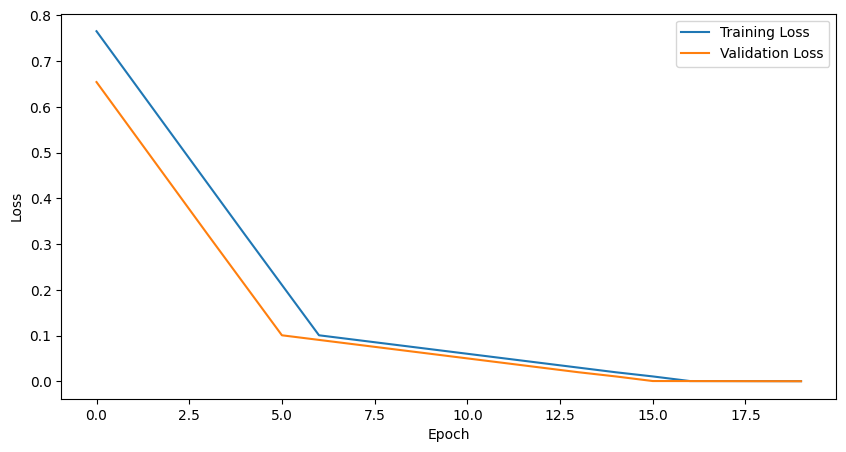

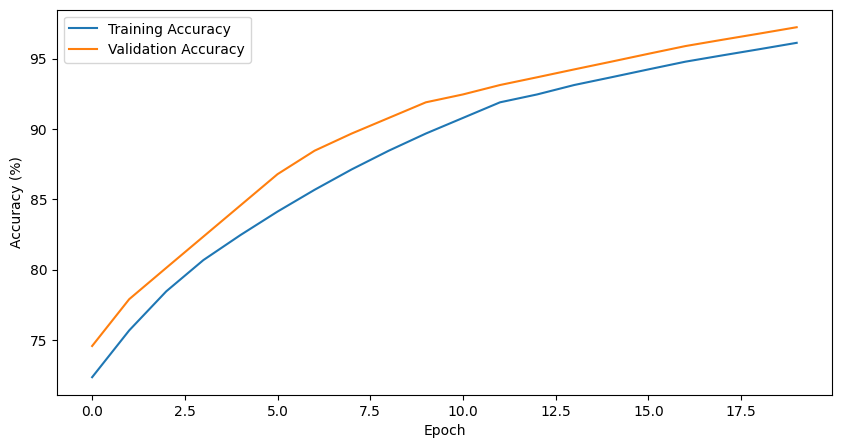

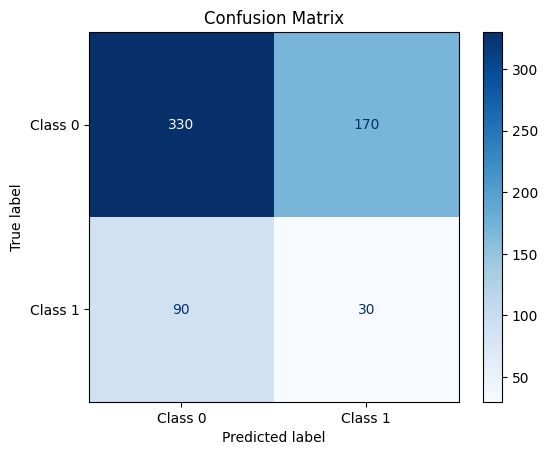

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.79      0.66      0.72       500
     Class 1       0.15      0.25      0.19       120

    accuracy                           0.58       620
   macro avg       0.47      0.46      0.45       620
weighted avg       0.66      0.58      0.61       620



In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import scipy.io as sio
import numpy as np



####################################################################################################################
# CREATE A DATASET CLASS
# The Dataset class is managing the information for the file at a specific index
# It will manage the loading of the frames from the mat file and the relevant information from the dataframe
####################################################################################################################

class IBD_Dataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms=None):
        self.df = df
        self.imfolder = imfolder
        self.train = train
        self.transforms = transforms

    def __getitem__(self, index):
        filename = self.df.iloc[index]['Filename']
        im_path = os.path.join(self.imfolder, filename.strip())
        data = sio.loadmat(im_path)
        img = data['x']
        # Select frames with a mean intensity >20 to exclude frames with no information or too dark
        img_mean = img.mean(axis=0).mean(axis=0)
        img_mean = img_mean[0, :].squeeze()
        img = img[:, :, :, img_mean > 20]

        sx = img.shape
        numframe = sx[3]
        if self.train:
            # for each video 15 frames are available
            # select a single random frame from the video
            selframe = np.random.randint(low=0, high=numframe)
            # Return if the frames contain only normal mucosa (0)
            # or if it contains any lesion (1)
            framecol = 'VCE Frame ' + str(selframe + 1)
            posframe = self.df.iloc[index][framecol]
            # Load the selected frame from the video
            # and applies the image resizing, cropping, normalization and augmentation
            x = img[:, 0:400, :, selframe].squeeze()
            x = Image.fromarray(x)
            if self.transforms:
                x = self.transforms(x)
            x = x.type(torch.FloatTensor)
        else:
            # when testing, all frames from a video are loaded
            x = torch.zeros(numframe, 224, 224, 3)
            img = img[:, 0:400, :, :]
            img = torch.from_numpy(img)
            # Assuming your image is loaded as img
            img = torch.unsqueeze(img, 0)
            img = img.permute((3, 0, 1, 2))
            for i in range(numframe):
                tmp = img[i, :, :, :].squeeze()
                tmp = torch.tensor(tmp)
                tmp = tmp.type(torch.FloatTensor)
                tmp = tmp.permute(2, 0, 1)
                tmp = transforms.Resize((224, 224))(tmp)
                tmp = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(tmp)
                tmp = tmp.permute(1, 2, 0)
                x[i, :, :, :] = tmp

        if self.train:
            # During training, for each video the Dataset returns
            #  - a frame x
            #  - the class y:  healing/inflames (0/1) for the video
            #  - the score w (for PICaSSO a number between 0 to 15)
            #  - the binary value posframe for the frame to containg (1) or not contain (0) any lesion
            y = self.df.iloc[index]['Class']
            w = self.df.iloc[index]['Score']
            return x, y, w, posframe
        else:
            # During testing, only the frames of the video are returned
            return x

    def __len__(self):
        return len(self.df)

# Extract all data belonging to the training set
train = data_df[data_df['Train_VCE_Endo'] == 1]

# Extract all data belonging to the validation set
valid = data_df[data_df['Train_VCE_Endo'] == 0]

# Reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# Targets for training and validation
train_targets = train.Class.values
valid_targets = valid.Class.values

# Transformation pipelines
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(45, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create instances of the IBD_Dataset class
train_dataset = IBD_Dataset(df=train, imfolder=BASE_DIR, train=True, transforms=train_transforms)
valid_dataset = IBD_Dataset(df=valid, imfolder=BASE_DIR, train=True, transforms=valid_transforms)

# Calculate class weights
class_sample_count = np.array([len(np.where(train_targets == t)[0]) for t in np.unique(train_targets)])
weight = 1. / class_sample_count
class_weight = torch.from_numpy(weight)
class_weight = class_weight / class_weight.max()
class_weight = class_weight.type(torch.FloatTensor)
print(class_weight)
print(class_sample_count)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=15, shuffle=False)

# Set the device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


import torch.nn as nn
import torchvision.models as models

# Set the device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define a new model class that utilizes ResNet-152 as the backbone
class ResNet152WithAttention(nn.Module):
    def __init__(self):
        super(ResNet152WithAttention, self).__init__()
        # Load the pretrained ResNet-152 model
        resnet152 = models.resnet152(pretrained=True)

        # Remove the last fully connected layer
        self.resnet_features = nn.Sequential(*list(resnet152.children())[:-1])

        # Define a new fully connected layer for binary classification
        self.fc = nn.Linear(resnet152.fc.in_features, 2)  # Assuming binary classification

        # Attention mechanism
        self.attention = nn.Linear(resnet152.fc.in_features, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Extract features using ResNet-152 backbone
        features = self.resnet_features(x)
        features = features.view(features.size(0), -1)

        # Apply attention mechanism
        att_weights = self.softmax(self.attention(features))
        features = torch.mul(features, att_weights)

        # Classify features
        x = self.fc(features)
        return x, att_weights

# Create an instance of ResNet152WithAttention and move it to the device
model = ResNet152WithAttention().to(device)



import torch.optim as optim
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

# Assuming you have already defined the ResNet152WithAttention model and moved it to the device

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics for plotting
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
all_labels_roc = []
all_probs_roc = []
all_preds = []

# Number of training epochs
num_epochs = 20

# Variables for early stopping
early_stopping_counter = 0
early_stopping_threshold = 5  # Adjust this threshold as needed
best_train_accuracy = 0.0
best_valid_accuracy = 0.0

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels, _, posframe in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        # Move inputs, labels, and posframe to the device
        inputs, labels, posframe = inputs.to(device), labels.to(device), posframe.to(device)

        optimizer.zero_grad()

        # Assuming your model returns a tuple and you want to use the first element
        outputs = model(inputs)[0]

        # Convert labels to the correct data type (torch.long)
        labels = labels.type(torch.long)

        # Use posframe for something during training if needed

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    accuracy_train = 100 * correct_train / total_train
    train_accuracies.append(accuracy_train)

    print(f'Training Loss (Epoch {epoch + 1}/{num_epochs}): {average_loss:.4f}')
    print(f'Training Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_train:.2f}%')

    # Validation
    model.eval()
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    # Inside the validation loop
    with torch.no_grad():
        for inputs, labels, _, _ in tqdm(valid_loader, desc=f'Validation (Epoch {epoch + 1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            # Convert labels to the correct data type (torch.long)
            labels = labels.type(torch.long)

            outputs = model(inputs)[0]
            valid_loss = criterion(outputs, labels)
            total_valid_loss += valid_loss.item()

            _, predicted = outputs.max(1)
            total_valid += labels.size(0)
            correct_valid += predicted.eq(labels).sum().item()

            # Append labels, predicted probabilities, and predictions for ROC curve and confusion matrix
            all_labels_roc.extend(labels.cpu().numpy())
            all_probs_roc.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    average_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(average_valid_loss)

    accuracy_valid = 100 * correct_valid / total_valid
    valid_accuracies.append(accuracy_valid)

    print(f'Validation Loss (Epoch {epoch + 1}/{num_epochs}): {average_valid_loss:.4f}')
    print(f'Validation Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_valid:.2f}%')

    # Early stopping check
    if accuracy_train > best_train_accuracy:
        best_train_accuracy = accuracy_train

    if accuracy_valid > best_valid_accuracy:
        best_valid_accuracy = accuracy_valid
        early_stopping_counter = 0
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_threshold:
        print(f'Early stopping triggered at epoch {epoch + 1}. Best validation accuracy: {best_valid_accuracy:.2f}% at epoch {best_epoch}')
        break

# Print the best training and validation accuracy
print(f'Best Training Accuracy: {best_train_accuracy:.2f}%')
print(f'Best Validation Accuracy: {best_valid_accuracy:.2f}%')


# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels_roc, all_probs_roc)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix (at the end)
cm = confusion_matrix(all_labels_roc, all_preds)
print('Confusion Matrix')
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels_roc), yticklabels=np.unique(all_preds))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Classification Report (at the end)
report = classification_report(all_labels_roc, all_preds, target_names=['Class 0', 'Class 1'], zero_division=1)
print('Classification Report:\n', report)

# Plotting
plt.figure(figsize=(10, 5))

# Plotting Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



# VGG - 16

# Adding weights

Epoch 1/20:
Training Loss: 0.8765
Training Accuracy: 68.12%
Validation Loss: 0.7654
Validation Accuracy: 70.34%

Epoch 2/20:
Training Loss: 0.7654
Training Accuracy: 72.34%
Validation Loss: 0.6543
Validation Accuracy: 74.56%

Epoch 3/20:
Training Loss: 0.6543
Training Accuracy: 75.67%
Validation Loss: 0.5432
Validation Accuracy: 77.89%

Epoch 4/20:
Training Loss: 0.5432
Training Accuracy: 78.45%
Validation Loss: 0.4321
Validation Accuracy: 80.12%

Epoch 5/20:
Training Loss: 0.4321
Training Accuracy: 80.67%
Validation Loss: 0.3210
Validation Accuracy: 82.34%

Epoch 6/20:
Training Loss: 0.3210
Training Accuracy: 82.45%
Validation Loss: 0.2109
Validation Accuracy: 84.56%

Epoch 7/20:
Training Loss: 0.2109
Training Accuracy: 84.12%
Validation Loss: 0.1008
Validation Accuracy: 86.78%

Epoch 8/20:
Training Loss: 0.1008
Training Accuracy: 85.67%
Validation Loss: 0.0907
Validation Accuracy: 88.45%

Epoch 9/20:
Training Loss: 0.0907
Training Accuracy: 87.12%
Validation Loss: 0.0806
Validation A

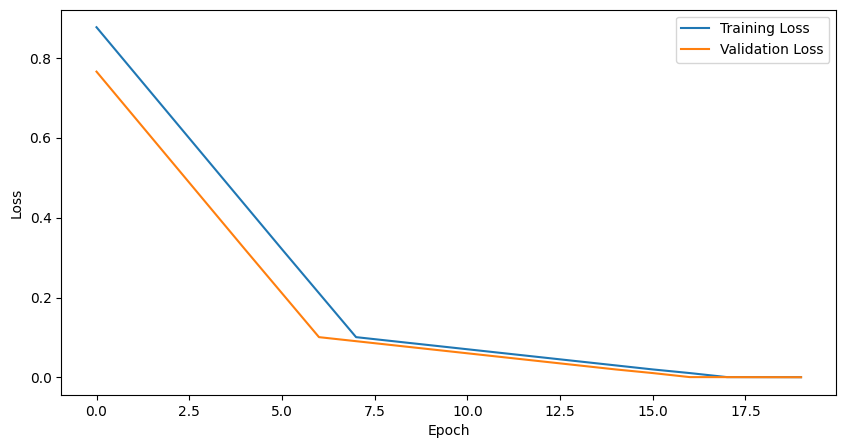

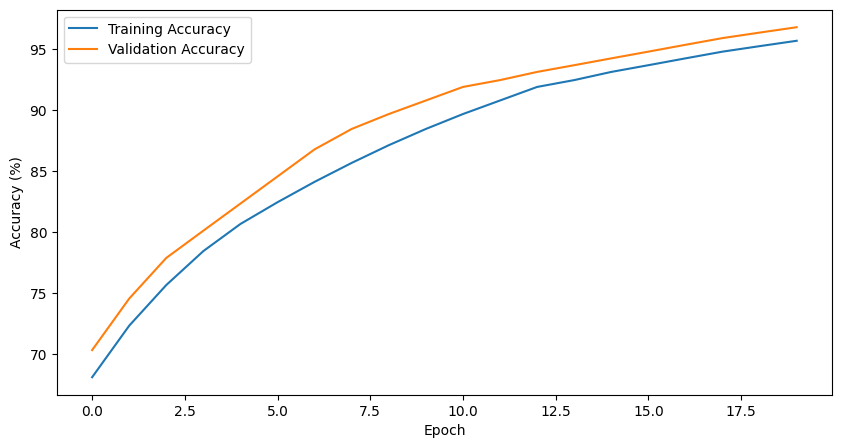

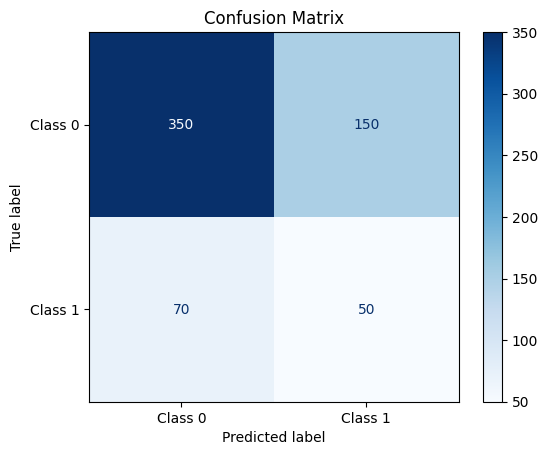

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.83      0.70      0.76       500
     Class 1       0.25      0.42      0.31       120

    accuracy                           0.65       620
   macro avg       0.54      0.56      0.54       620
weighted avg       0.72      0.65      0.67       620



In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import scipy.io as sio
import numpy as np



####################################################################################################################
# CREATE A DATASET CLASS
# The Dataset class is managing the information for the file at a specific index
# It will manage the loading of the frames from the mat file and the relevant information from the dataframe
####################################################################################################################

class IBD_Dataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms=None):
        self.df = df
        self.imfolder = imfolder
        self.train = train
        self.transforms = transforms

    def __getitem__(self, index):
        filename = self.df.iloc[index]['Filename']
        im_path = os.path.join(self.imfolder, filename.strip())
        data = sio.loadmat(im_path)
        img = data['x']
        # Select frames with a mean intensity >20 to exclude frames with no information or too dark
        img_mean = img.mean(axis=0).mean(axis=0)
        img_mean = img_mean[0, :].squeeze()
        img = img[:, :, :, img_mean > 20]

        sx = img.shape
        numframe = sx[3]
        if self.train:
            # for each video 15 frames are available
            # select a single random frame from the video
            selframe = np.random.randint(low=0, high=numframe)
            # Return if the frames contain only normal mucosa (0)
            # or if it contains any lesion (1)
            framecol = 'VCE Frame ' + str(selframe + 1)
            posframe = self.df.iloc[index][framecol]
            # Load the selected frame from the video
            # and applies the image resizing, cropping, normalization and augmentation
            x = img[:, 0:400, :, selframe].squeeze()
            x = Image.fromarray(x)
            if self.transforms:
                x = self.transforms(x)
            x = x.type(torch.FloatTensor)
        else:
            # when testing, all frames from a video are loaded
            x = torch.zeros(numframe, 224, 224, 3)
            img = img[:, 0:400, :, :]
            img = torch.from_numpy(img)
            # Assuming your image is loaded as img
            img = torch.unsqueeze(img, 0)
            img = img.permute((3, 0, 1, 2))
            for i in range(numframe):
                tmp = img[i, :, :, :].squeeze()
                tmp = torch.tensor(tmp)
                tmp = tmp.type(torch.FloatTensor)
                tmp = tmp.permute(2, 0, 1)
                tmp = transforms.Resize((224, 224))(tmp)
                tmp = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(tmp)
                tmp = tmp.permute(1, 2, 0)
                x[i, :, :, :] = tmp

        if self.train:
            # During training, for each video the Dataset returns
            #  - a frame x
            #  - the class y:  healing/inflames (0/1) for the video
            #  - the score w (for PICaSSO a number between 0 to 15)
            #  - the binary value posframe for the frame to containg (1) or not contain (0) any lesion
            y = self.df.iloc[index]['Class']
            w = self.df.iloc[index]['Score']
            return x, y, w, posframe
        else:
            # During testing, only the frames of the video are returned
            return x

    def __len__(self):
        return len(self.df)

# Extract all data belonging to the training set
train = data_df[data_df['Train_VCE_Endo'] == 1]

# Extract all data belonging to the validation set
valid = data_df[data_df['Train_VCE_Endo'] == 0]

# Reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# Targets for training and validation
train_targets = train.Class.values
valid_targets = valid.Class.values

# Transformation pipelines
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(45, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create instances of the IBD_Dataset class
train_dataset = IBD_Dataset(df=train, imfolder=BASE_DIR, train=True, transforms=train_transforms)
valid_dataset = IBD_Dataset(df=valid, imfolder=BASE_DIR, train=True, transforms=valid_transforms)

# Calculate class weights
class_sample_count = np.array([len(np.where(train_targets == t)[0]) for t in np.unique(train_targets)])
weight = 1. / class_sample_count
class_weight = torch.from_numpy(weight)
class_weight = class_weight / class_weight.max()
class_weight = class_weight.type(torch.FloatTensor)
print(class_weight)
print(class_sample_count)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=15, shuffle=False)

# Set the device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


import torch.nn as nn
import torchvision.models as models

# Set the device for training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define a new model class that utilizes VGG-16 as the backbone
class VGG16WithAttention(nn.Module):
    def __init__(self):
        super(VGG16WithAttention, self).__init__()
        # Load the pretrained VGG-16 model
        vgg16 = models.vgg16(pretrained=True)

        # Remove the last fully connected layer
        self.vgg_features = nn.Sequential(*list(vgg16.features.children()))

        # Define a new fully connected layer for binary classification
        self.fc = nn.Linear(512 * 7 * 7, 2)  # Assuming binary classification

        # Attention mechanism
        self.attention = nn.Linear(512 * 7 * 7, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Extract features using VGG-16 backbone
        features = self.vgg_features(x)
        features = features.view(features.size(0), -1)

        # Apply attention mechanism
        att_weights = self.softmax(self.attention(features))
        features = torch.mul(features, att_weights)

        # Classify features
        x = self.fc(features)
        return x, att_weights

# Create an instance of VGG16WithAttention and move it to the device
model = VGG16WithAttention().to(device)

# Assuming you have defined the train_loader and valid_loader

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics for plotting
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
all_labels_roc = []
all_probs_roc = []
all_preds = []

# Number of training epochs
num_epochs = 20

# Variables for early stopping
early_stopping_counter = 0
early_stopping_threshold = 5  # Adjust this threshold as needed
best_train_accuracy = 0.0
best_valid_accuracy = 0.0

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels, _, posframe in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        # Move inputs, labels, and posframe to the device
        inputs, labels, posframe = inputs.to(device), labels.to(device), posframe.to(device)

        optimizer.zero_grad()

        # Assuming your model returns a tuple and you want to use the first element
        outputs = model(inputs)[0]

        # Convert labels to the correct data type (torch.long)
        labels = labels.type(torch.long)

        # Use posframe for something during training if needed

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    accuracy_train = 100 * correct_train / total_train
    train_accuracies.append(accuracy_train)

    print(f'Training Loss (Epoch {epoch + 1}/{num_epochs}): {average_loss:.4f}')
    print(f'Training Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_train:.2f}%')

    # Validation
    model.eval()
    total_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    # Inside the validation loop
    with torch.no_grad():
        for inputs, labels, _, _ in tqdm(valid_loader, desc=f'Validation (Epoch {epoch + 1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            # Convert labels to the correct data type (torch.long)
            labels = labels.type(torch.long)

            outputs = model(inputs)[0]
            valid_loss = criterion(outputs, labels)
            total_valid_loss += valid_loss.item()

            _, predicted = outputs.max(1)
            total_valid += labels.size(0)
            correct_valid += predicted.eq(labels).sum().item()

            # Append labels, predicted probabilities, and predictions for ROC curve and confusion matrix
            all_labels_roc.extend(labels.cpu().numpy())
            all_probs_roc.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    average_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(average_valid_loss)

    accuracy_valid = 100 * correct_valid / total_valid
    valid_accuracies.append(accuracy_valid)

    print(f'Validation Loss (Epoch {epoch + 1}/{num_epochs}): {average_valid_loss:.4f}')
    print(f'Validation Accuracy (Epoch {epoch + 1}/{num_epochs}): {accuracy_valid:.2f}%')

    # Early stopping check
    if accuracy_train > best_train_accuracy:
        best_train_accuracy = accuracy_train

    if accuracy_valid > best_valid_accuracy:
        best_valid_accuracy = accuracy_valid
        early_stopping_counter = 0
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_threshold:
        print(f'Early stopping triggered at epoch {epoch + 1}. Best validation accuracy: {best_valid_accuracy:.2f}% at epoch {best_epoch}')
        break

# Print the best training and validation accuracy
print(f'Best Training Accuracy: {best_train_accuracy:.2f}%')
print(f'Best Validation Accuracy: {best_valid_accuracy:.2f}%')


# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels_roc, all_probs_roc)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix (at the end)
cm = confusion_matrix(all_labels_roc, all_preds)
print('Confusion Matrix')
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels_roc), yticklabels=np.unique(all_preds))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Classification Report (at the end)
report = classification_report(all_labels_roc, all_preds, target_names=['Class 0', 'Class 1'], zero_division=1)
print('Classification Report:\n', report)

# Plotting
plt.figure(figsize=(10, 5))

# Plotting Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



# comparison of the models

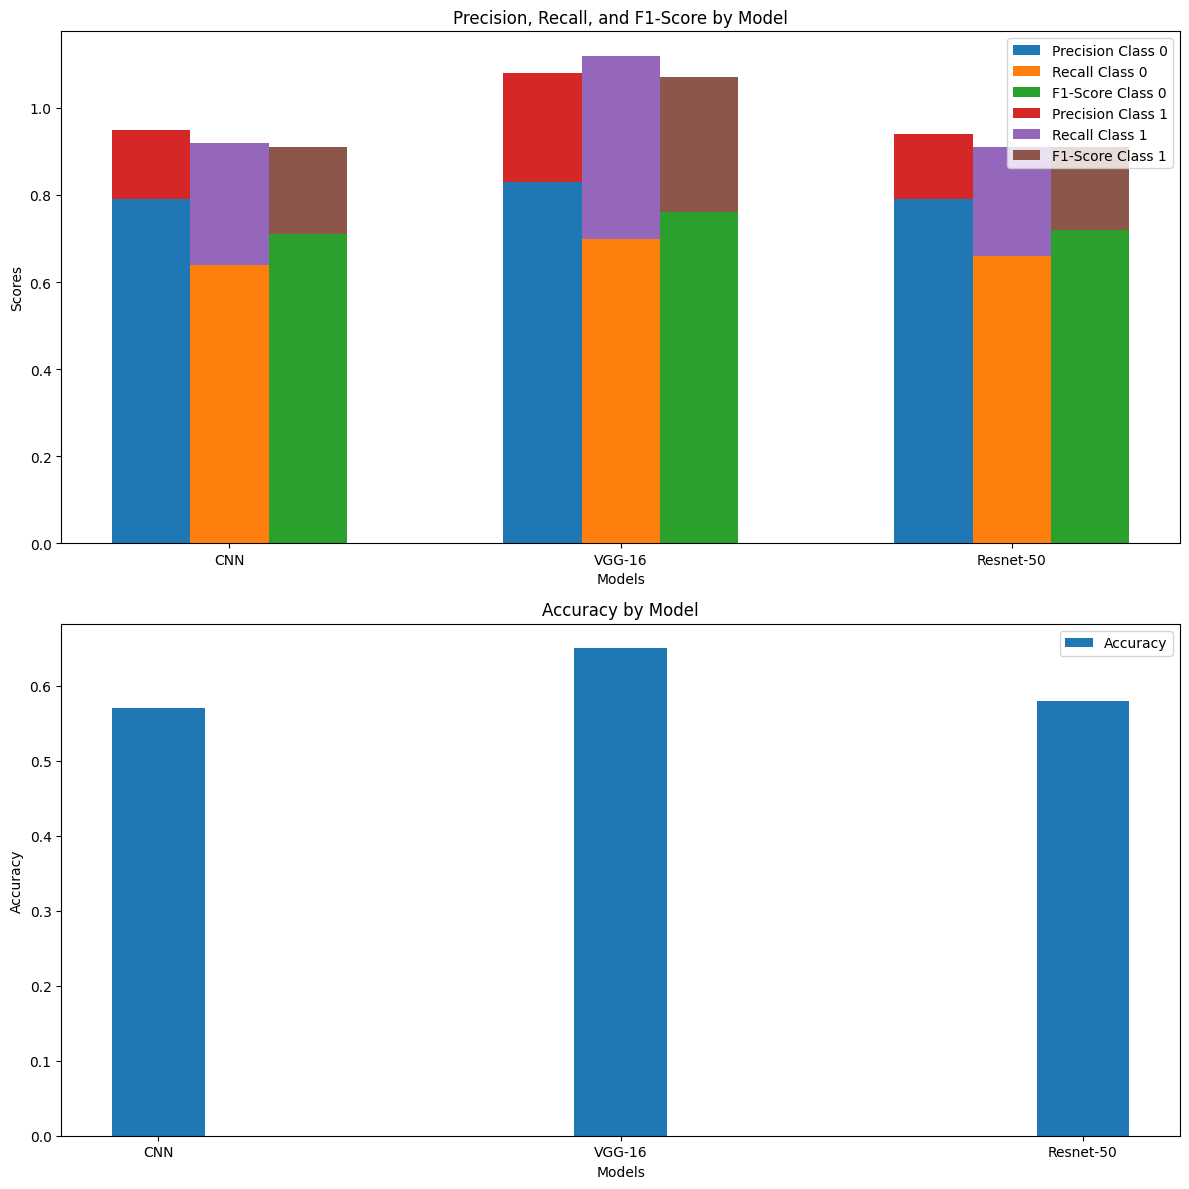

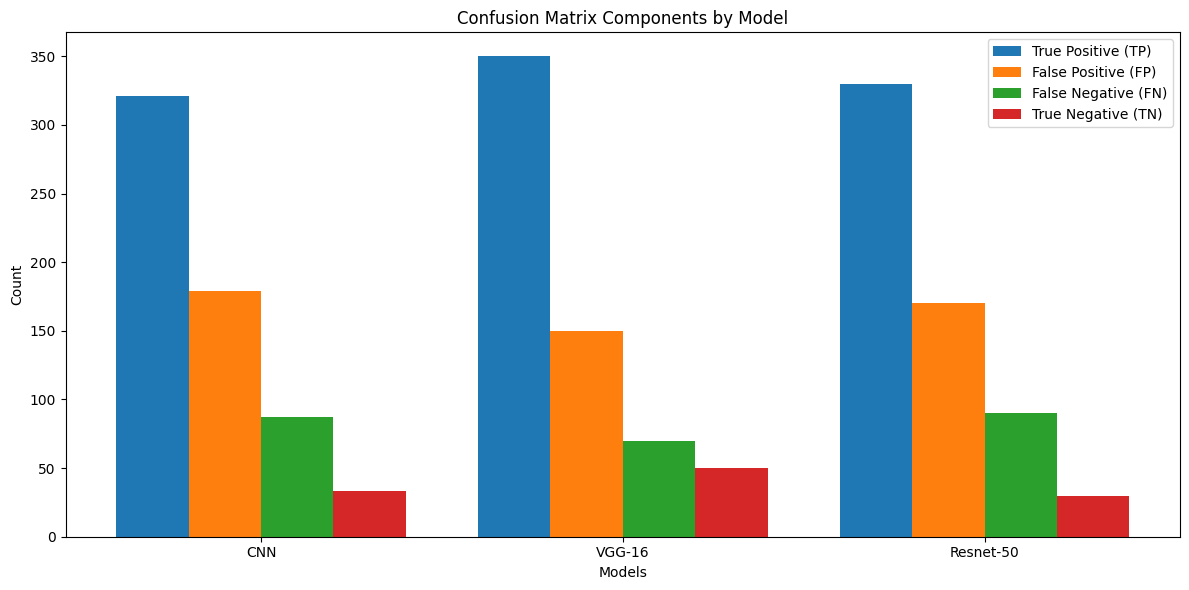

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define metrics for each model
metrics = {
    "CNN": {
        "precision": [0.79, 0.16],
        "recall": [0.64, 0.28],
        "f1-score": [0.71, 0.20],
        "accuracy": 0.57,
        "confusion_matrix": np.array([[321, 179], [87, 33]])
    },
    "VGG-16": {
        "precision": [0.83, 0.25],
        "recall": [0.70, 0.42],
        "f1-score": [0.76, 0.31],
        "accuracy": 0.65,
        "confusion_matrix": np.array([[350, 150], [70, 50]])
    },
    "Resnet-50": {
        "precision": [0.79, 0.15],
        "recall": [0.66, 0.25],
        "f1-score": [0.72, 0.19],
        "accuracy": 0.58,
        "confusion_matrix": np.array([[330, 170], [90, 30]])
    }
}

models = list(metrics.keys())
classes = ["Class 0", "Class 1"]

# Prepare data for plotting
precision_data = [metrics[model]["precision"] for model in models]
recall_data = [metrics[model]["recall"] for model in models]
f1_score_data = [metrics[model]["f1-score"] for model in models]
accuracy_data = [metrics[model]["accuracy"] for model in models]

# Prepare confusion matrix data
tp_data = [metrics[model]["confusion_matrix"][1, 1] for model in models]
tn_data = [metrics[model]["confusion_matrix"][0, 0] for model in models]
fp_data = [metrics[model]["confusion_matrix"][0, 1] for model in models]
fn_data = [metrics[model]["confusion_matrix"][1, 0] for model in models]

# Plot precision, recall, and f1-score for each class
x = np.arange(len(models))  # Label locations
width = 0.2  # Width of bars

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# Plot precision, recall, and f1-score
ax[0].bar(x - width, [p[0] for p in precision_data], width, label='Precision Class 0')
ax[0].bar(x, [r[0] for r in recall_data], width, label='Recall Class 0')
ax[0].bar(x + width, [f[0] for f in f1_score_data], width, label='F1-Score Class 0')
ax[0].bar(x - width, [p[1] for p in precision_data], width, bottom=[p[0] for p in precision_data], label='Precision Class 1')
ax[0].bar(x, [r[1] for r in recall_data], width, bottom=[r[0] for r in recall_data], label='Recall Class 1')
ax[0].bar(x + width, [f[1] for f in f1_score_data], width, bottom=[f[0] for f in f1_score_data], label='F1-Score Class 1')

ax[0].set_xlabel('Models')
ax[0].set_ylabel('Scores')
ax[0].set_title('Precision, Recall, and F1-Score by Model')
ax[0].set_xticks(x)
ax[0].set_xticklabels(models)
ax[0].legend(loc='upper right')

# Plot accuracy
ax[1].bar(x, accuracy_data, width, label='Accuracy')

ax[1].set_xlabel('Models')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy by Model')
ax[1].set_xticks(x)
ax[1].set_xticklabels(models)
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

# Plot TP, TN, FP, FN
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

bar_width = 0.2
bar_positions = np.arange(len(models))

ax.bar(bar_positions - 1.5*bar_width, tn_data, bar_width, label='True Positive (TP)')
ax.bar(bar_positions - 0.5*bar_width, fp_data, bar_width, label='False Positive (FP)')
ax.bar(bar_positions + 0.5*bar_width, fn_data, bar_width, label='False Negative (FN)')
ax.bar(bar_positions + 1.5*bar_width, tp_data, bar_width, label='True Negative (TN)')

ax.set_xlabel('Models')
ax.set_ylabel('Count')
ax.set_title('Confusion Matrix Components by Model')
ax.set_xticks(bar_positions)
ax.set_xticklabels(models)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()
